# MT + Transformer

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:2


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
torchtext.__version__

'0.14.1'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
#uncomment this if you are not using our department puffer
# import os
# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'de'

train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('Two young, White males are outside near many bushes.',
 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.')

In [8]:
train_size = len(list(iter(train)))
train_size

29001

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [9]:
train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [10]:
train_size = len(list(iter(train)))
train_size

20301

In [11]:
val_size = len(list(iter(val)))
val_size

5800

In [12]:
test_size = len(list(iter(test)))
test_size

2900

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [13]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [14]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [15]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  Two young, White males are outside near many bushes.
Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


A function to tokenize our input.

In [16]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [17]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [18]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [19]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1891, 10, 4, 0, 4]

In [20]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'here'

In [21]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [22]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [23]:
#check unique vocabularies
len(mapping)

5174

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [26]:
for en, _, de in train_loader:
    break

In [27]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("German shape: ", de.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 27])
German shape:  torch.Size([64, 24])


## 5. Design the model

### Encoder

<img src="../figures/transformer-encoder.png" >

In [28]:
class Encoder(nn.Module):
   def __init__(self, input_dim, hid_dim, n_layers, n_heads,
               pf_dim, dropout, device, max_length = 100):
      super().__init__()
      self.pos_emb = nn.Embedding(max_length, hid_dim)
      self.src_emb = nn.Embedding(input_dim, hid_dim)
      self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
      self.dropout = nn.Dropout(dropout)
      self.layers = nn.ModuleList(
                        [
                           EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                           for _ in range(n_layers)
                        ]
                        )
      self.device = device

   def forward(self, src, src_mask):
      #src : = [batch size, src len]
      b = src.shape[0]
      l = src.shape[1]

      #pos
      pos = torch.arange(0,l).unsqueeze(0).repeat(b, 1).to(self.device)
      #pos : [b,l]

      pos_emb = self.pos_emb(pos) #[b,l,h]
      src_emb = self.src_emb(src) #[b,l,h]

      x = pos_emb + src_emb * self.scale #[b,l,h]
      x = self.dropout(x)

      for layer in self.layers:
         src = layer(x, src_mask)
         
      return src

### Encoder Layer

In [29]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.norm_att = nn.LayerNorm(hid_dim) #first green box 
        self.norm_ff = nn.LayerNorm(hid_dim) #second green box
        self.multi = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.ff = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #first block
        _src, _ = self.multi(src, src, src, src_mask) #Q, K, V
        _src    = self.dropout(_src)
        _src    = src + _src
        src    = self.norm_att(_src)
        
        #second block
        _src    = self.ff(src)
        _src    = self.dropout(_src)
        _src    = src + _src
        src    = self.norm_ff(_src)
        #src : [b,l,h]

        return src

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

In [30]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads #make sure it's divisible....

        self.fc_q = nn.Linear(hid_dim,hid_dim) 
        self.fc_k = nn.Linear(hid_dim,hid_dim) 
        self.fc_v = nn.Linear(hid_dim,hid_dim) 

        self.fc = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, q, k, v, mask = None):
        batch_size = q.shape[0]
        
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)
        #Q, K, V = [b, l, h]
        #reshape them into head_dim
        #reshape them to [b, n_headm, l, head_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        #Q, K, V = [b, m_head, l, head_dim]

        #e = QK/sqrt(dk)
        e =  torch.matmul(Q, K.permute(0,1,3,2)) / self.scale
        #e = [b, n_heads, ql, kl]

        if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)

        a = torch.softmax(e, dim=-1)
        #a = [batch size, n_heads, ql, kl]
                    
        #eV
        x = torch.matmul(self.dropout(a),V)
        #x : [b, n_heads, ql, head_di]

        x = x.permute(0, 2, 1, 3).contiguous()
        #x: [b, ql, n_heads, head_dim]

        #concat them together
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [b, ql, h]

        x = self.fc(x)
        #x = [b, ql, h]

        return x, a

### Position-wise Feedforward Layer

In [31]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(torch.relu(self.fc1(x))))

### Decoder

<img src = "../figures/transformer-decoder.png" >


In [32]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.pos_emb = nn.Embedding(max_length, hid_dim)
        self.trg_emb = nn.Embedding(output_dim, hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
                            [
                            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                            for _ in range(n_layers)
                            ]
                            )
        self.fc = nn.Linear(hid_dim, output_dim)
        self.device = device
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        #src : = [batch size, trg len]
        #enc_src : hidden state from encoder = [b, sl, h]
        #trg_mask = [b, 1, tl, tl]
        #src_mask = [b, 1, 1, sl]
        b = trg.shape[0]
        l = trg.shape[1]

        #pos
        pos = torch.arange(0,l).unsqueeze(0).repeat(b, 1).to(self.device)
        #pos : [b,l]

        pos_emb = self.pos_emb(pos) #[b,l,h]
        trg_emb = self.trg_emb(trg) #[b,l,h]

        x = pos_emb + trg_emb * self.scale #[b,l,h]
        x = self.dropout(x)

        for layer in self.layers:
            trg, attention = layer(x, enc_src, trg_mask, src_mask)

        output = self.fc(trg)

        return output, attention

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [49]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()

        self.norm_att = nn.LayerNorm(hid_dim) #second green box 
        self.norm_ff = nn.LayerNorm(hid_dim) #third green box
        self.norm_maskedatt = nn.LayerNorm(hid_dim) #first green box

        self.multi_masked = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.multi_cross = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        
        self.ff = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg      : [b, l, h]
        #enc_src  : [b, sl, h]
        #trg_mask : [b, 1, tl, tl]
        #src_mask : [b, 1, 1, sl]

        #1st box : mask multi, add & norm
        _trg, _ = self.multi_masked(trg, trg, trg, trg_mask) #Q, K, V
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_maskedatt(_trg)

        #2nd box : multi cross, add & norm
        _trg, attention = self.multi_cross(trg, enc_src, enc_src, src_mask) #Q, K, V
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_att(_trg)

        #3rd box : ff, add & norm
        _trg    = self.ff(trg)
        _trg    = self.dropout(_trg)
        _trg    = trg + _trg
        trg     = self.norm_ff(_trg)


        return trg, attention

### Putting them together (become Seq2Seq!)

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape `[batch size, n heads, seq len, seq len]`.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of `[1, 0, 0, 0, 0]` which means it can only look at the first target token. The second target token has a mask of `[1, 1, 0, 0, 0]` which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [50]:
trg_sub_mask = torch.tril(torch.ones((3,3))).bool()
trg_sub_mask #(l, l)

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

In [51]:
trg_mask = torch.LongTensor([1,1,0])
trg_mask #(l,)

tensor([1, 1, 0])

In [52]:
trg_mask = trg_mask.unsqueeze(0).unsqueeze(1).unsqueeze(2)
trg_mask.shape #(b, 1, 1, l)

torch.Size([1, 1, 1, 3])

In [53]:
trg_mask & trg_sub_mask #(b, 1, l, l)

tensor([[[[1, 0, 0],
          [1, 1, 0],
          [1, 1, 0]]]])

In [54]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, enc, dec, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.encoder = enc
        self.decoder = dec
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self,src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask : [b, 1, 1, l]
        return src_mask

    def make_trg_mask(self,trg):
        trg_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_mask : [b, 1, 1, l]        
        
        trg_len = trg_mask.shape[-1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len,trg_len), device =self.device)).bool() #lower triangle
        
        trg_mask = trg_mask & trg_sub_mask 
        #src_mask : [b, 1, l, l]
        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        #1. learn some mask from src and trg
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        #2. encoder
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        #3. decoder
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        #output : [batch size, trg len, output dim]
        #attention : [batch size, heads, trg len, src len]
        
        return output, attention 
        #output outputs the translated sentence
        #attention outputs the attention between src and trg

## 6. Training

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [55]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [56]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [57]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (pos_emb): Embedding(100, 256)
    (src_emb): Embedding(5174, 256)
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_att): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm_ff): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (multi): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropo

In [58]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

 25600
1324544
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
 25600
1646848
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1646848
  6433
______
8629537


The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [59]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

In [60]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])  
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1)    #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [61]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [46]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [62]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [63]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 18s
	Train Loss: 3.898 | Train PPL:  49.307
	 Val. Loss: 2.695 |  Val. PPL:  14.805
Epoch: 02 | Time: 0m 17s
	Train Loss: 2.524 | Train PPL:  12.474
	 Val. Loss: 2.007 |  Val. PPL:   7.444
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.028 | Train PPL:   7.598
	 Val. Loss: 1.600 |  Val. PPL:   4.951
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.702 | Train PPL:   5.487
	 Val. Loss: 1.345 |  Val. PPL:   3.836
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.488 | Train PPL:   4.430
	 Val. Loss: 1.128 |  Val. PPL:   3.091
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.309 | Train PPL:   3.702
	 Val. Loss: 0.971 |  Val. PPL:   2.642
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.159 | Train PPL:   3.188
	 Val. Loss: 0.837 |  Val. PPL:   2.309
Epoch: 08 | Time: 0m 17s
	Train Loss: 1.057 | Train PPL:   2.878
	 Val. Loss: 0.742 |  Val. PPL:   2.099
Epoch: 09 | Time: 0m 17s
	Train Loss: 0.959 | Train PPL:   2.609
	 Val. Loss: 0.658 |  Val. PPL:   1.931
Epoch: 10 | Time: 0m 17s
	Train Loss: 0.880 | Train PPL

Text(0, 0.5, 'loss')

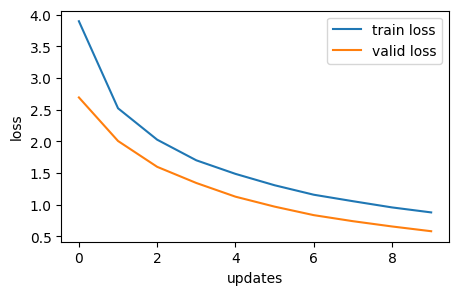

In [64]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [65]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.579 | Test PPL:   1.783 |


## 7. Test on some random news

In [66]:
sample[0]

'Two young, White males are outside near many bushes.'

In [67]:
sample[1]

'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'

In [68]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,   19,   25,   15, 1069,  842,   17,   56,   84,  331, 1623,    5,
           3], device='cuda:2')

In [69]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,   21,   83,  262,   32,   89,   22,   91,    7,   16,  115,    0,
        2893,    4,    3], device='cuda:2')

In [70]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [71]:
trg_text = trg_text.reshape(1, -1)

In [72]:
src_text.shape, trg_text.shape

(torch.Size([1, 13]), torch.Size([1, 15]))

In [73]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [74]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [75]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 15, 6433])

Since batch size is 1, we just take off that dimension

In [76]:
output = output.squeeze(0)

In [77]:
output.shape

torch.Size([15, 6433])

We shall remove the first token since it's zeroes anyway

In [78]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([14, 6433])

Then we just take the top token with highest probabilities

In [79]:
output_max = output.argmax(1) #returns max indices

In [80]:
output_max

tensor([  83,  262,   32,    9,  139,   91,    7,   16,  115,   24, 2893,    4,
           3,   89], device='cuda:2')

Get the mapping of the target language

In [81]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [82]:
for token in output_max:
    print(mapping[token.item()])

junge
weiße
Männer
,
draußen
Freien
in
der
Nähe
von
Büsche
.
<eos>
sind


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [83]:
attentions.shape

torch.Size([1, 8, 15, 13])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [84]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([15, 13])

In [85]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'Two',
 'young',
 ',',
 'White',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes',
 '.',
 '<eos>']

In [86]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'junge',
 'weiße',
 'Männer',
 ',',
 'draußen',
 'Freien',
 'in',
 'der',
 'Nähe',
 'von',
 'Büsche',
 '.',
 '<eos>',
 'sind']

In [87]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

/tmp/ipykernel_18201/59549304.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_18201/59549304.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


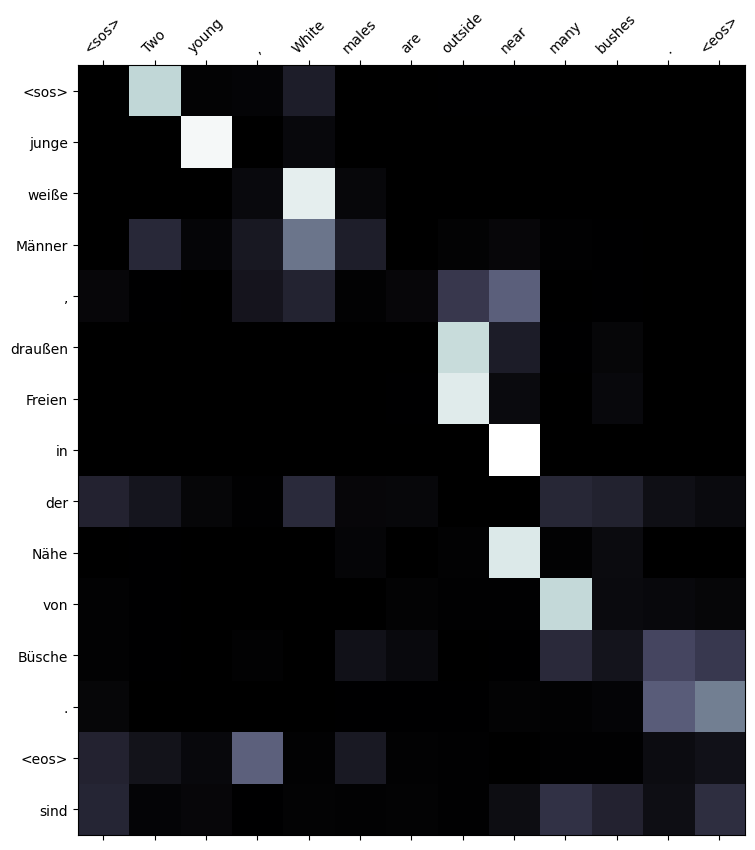

In [88]:
display_attention(src_tokens, trg_tokens, attention)